Library imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

#### Overview
Data source: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/<br>
Two data sets of wine quality ratings and quantitative data which is representative of laboratory testing.<br>
One set is for red wine and one set is for white.<br>
Typically, these two sets are used separately for supervised learning applications, but I'm going to merge them and see if they can be differentiated using unsupervised learning.<br>
I'm not a wine drinker (it all tastes like vinegar to me), but I'm guessing there's some difference between red and white (beyond the color) that makes them differentiable via unsupervised learning.<br>

The two datasets are imported and an additional column ("type") is created to store the matching label.<br>
This won't be used in the training, but will be used to assess classification accuracy.

In [2]:
ww_data = pd.read_csv("Wine Data\winequality-white.csv", header=0, sep=";")
rw_data = pd.read_csv("Wine Data\winequality-red.csv", header=0, sep=";")
ww_data["type"] = "white"
rw_data["type"] = "red"
print(f"White wine observations: {ww_data.shape[0]}")
print(f"Red wine observations: {rw_data.shape[0]}")
print(f"Combined observations: {ww_data.shape[0]+ rw_data.shape[0]}")

White wine observations: 4898
Red wine observations: 1599
Combined observations: 6497


In [3]:
display(ww_data.head())
display(rw_data.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Typically, this dataset has been used as a supervised learning example to try to predict quality ratings.<br>
I'm going to ignore the quality ratings for now and look at all of the other quantitative variables that will be used as predictors.<br>
The two datasets, having been labeled both with text and a numeric value, are combined for easier visualization and analysis.

In [4]:
wine_data = pd.concat([ww_data, rw_data], axis = 0, ignore_index = True)
wine_data["type_bin"] = 1
wine_data.loc[wine_data["type"] == "red","type_bin"] = 0

In [5]:
wine_data.columns.tolist()
#["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality", "type"]
predictor_list = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

#### EDA Visualizations
Generate histograms of the distribution of each variable by wine type.<br>
(<i>I'm moderately colorblind, so I don't generally color-code anything by default, but it seems befitting for types of wine.</i>)

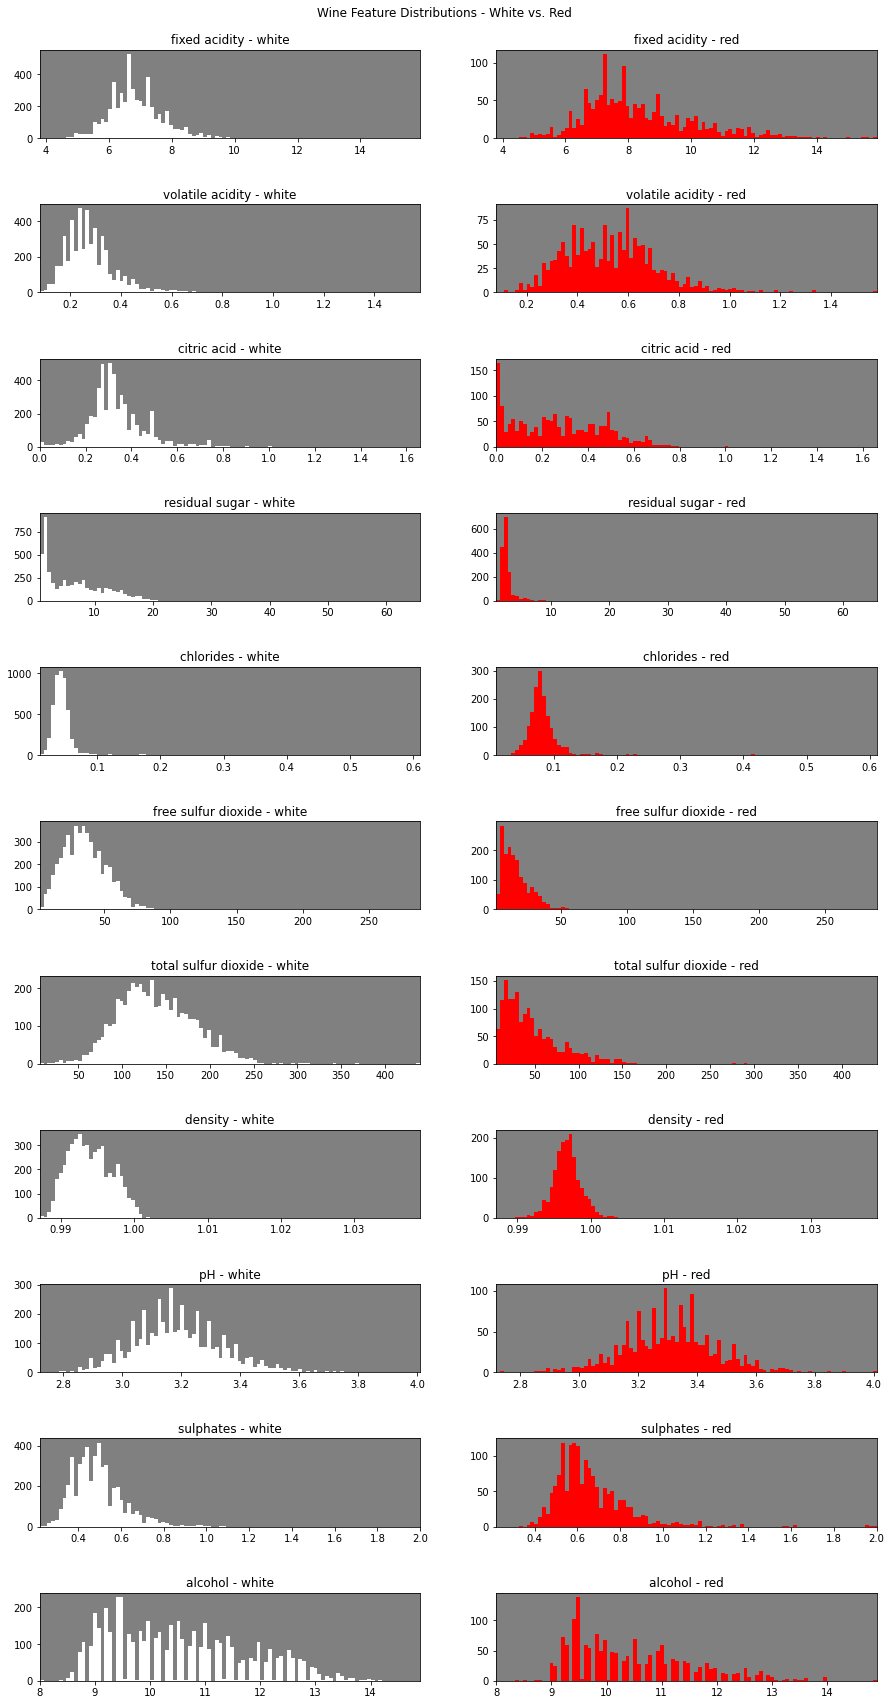

In [6]:
plt.figure(figsize = (15, 30))
plt.subplots_adjust(hspace = 0.75)
plt.suptitle("Wine Feature Distributions - White vs. Red", y = 0.90)

for r, var in enumerate(predictor_list):
    xlim_vals = (wine_data[var].min(), wine_data[var].max())
    for i, w_type in enumerate(["white", "red"]):
        ax = plt.subplot(len(predictor_list), 2, (2*r)+1+i)
        #wine_data.loc[(wine_data["type"] == w_type), var].plot(ax = ax, kind = "density")
        plt.hist(wine_data.loc[(wine_data["type"] == w_type), var], bins = 100, range = xlim_vals, density = False,
                color = w_type)
        ax.set_facecolor("grey")
        
        plt.title(f"{var} - {w_type}")
        plt.xlim(xlim_vals)
        plt.ylabel(None)    

#### EDA Correlation Matrix

In [7]:
wine_data[predictor_list].corr().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.00,0.22,0.32,-0.11,0.30,-0.28,-0.33,0.46,-0.25,0.30,-0.10
volatile acidity,0.22,1.00,-0.38,-0.20,0.38,-0.35,-0.41,0.27,0.26,0.23,-0.04
citric acid,0.32,-0.38,1.00,0.14,0.04,0.13,0.20,0.10,-0.33,0.06,-0.01
residual sugar,-0.11,-0.20,0.14,1.00,-0.13,0.40,0.50,0.55,-0.27,-0.19,-0.36
chlorides,0.30,0.38,0.04,-0.13,1.00,-0.20,-0.28,0.36,0.04,0.40,-0.26
free sulfur dioxide,-0.28,-0.35,0.13,0.40,-0.20,1.00,0.72,0.03,-0.15,-0.19,-0.18
total sulfur dioxide,-0.33,-0.41,0.20,0.50,-0.28,0.72,1.00,0.03,-0.24,-0.28,-0.27
density,0.46,0.27,0.10,0.55,0.36,0.03,0.03,1.00,0.01,0.26,-0.69
pH,-0.25,0.26,-0.33,-0.27,0.04,-0.15,-0.24,0.01,1.00,0.19,0.12
sulphates,0.30,0.23,0.06,-0.19,0.40,-0.19,-0.28,0.26,0.19,1.00,-0.00


No features appear to be fully separable (or even close) because there's significant overlap, but they've also got either very different shapes or sections of non-overlap.<br>
The highest inter-predictor correlation is for free and total sulfur dioxide, but that's because total sulfur dioxide is going to be the sum of free sulfur dioxide and bound sulfur dioxide. I'd consider eliminating one of these, but when you square the correlation coefficient to get a coefficient of determination, less than 50% of the variance is explained.<br>
From what I know about fermentation, density is a function of initial sugar and how much of it has been fermented into alcohol versus allowed to remain as residual sugars, so it's unsurprising to see the correlation figures there. Those coefficients would probably have greater magnitude if there was a consistent starting sugar concentration.<br>
If I was overly concerned about model complexity, I'd gravitate toward some form of dimensionality reduction (probably PCA), but at this scale and for this assignment, I'd prefer to skip that so that the resulting model is more interpretable and any relevant post-modeling visualizations don't lose interpretability through dimensonality reduction.<br>
Since we know we've got 2 groups of interest, I'd like to see how k-means handles categorizing them.<br>
<b>
- Hypothesis 1: Despite the absence of any color-specific variables, the quantitative features will provide for good separation of the two broad categories of wines using k-means.
- Hypothesis 2: The sulfur-related components will not have as much of an impact as other features. (Rationale: Sulfate free wines are advertised for individuals who have sensitivities to sulfates.)
</b>
    

Everything will need to be scaled becuase there's wildly different ranges of values.<br>
I'm going to leave the outliers in because there are relatively few of them and I don't have any reason to assume they're measurement errors, plus there's reason to assume significant heterogenity in the binary category we're predicting. (I.e. Lots of different types of wines are "whites" or "reds" and they're not a homogenous category.)

#### Unsupervised Learning Model 1 - K-Means (k=2) with all quantitative variables (excluding quality rating) from the original dataset.

In [8]:
pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('k-means', KMeans(n_clusters = 2, init = "random", n_init = 100, max_iter = 1000, random_state = 0))
])

In [9]:
pipe1_predictions = pipe1.fit_predict(wine_data[predictor_list].to_numpy())
pipe1_accuracy = accuracy_score(wine_data["type_bin"].to_numpy(), pipe1_predictions)
print(f"Model 1 Accuracy: {pipe1_accuracy}")
print("Confusion Matrix")
print(confusion_matrix(pipe1_predictions, wine_data["type_bin"].to_numpy()))

Model 1 Accuracy: 0.9858396182853625
Confusion Matrix
[[1575   68]
 [  24 4830]]


#### Unsupervised Learning Model 2 - K-Means (k=2) with the variables that are going to be most accessible to home analysis. Testing for sulphates or chlorides is going to be rather difficult, but pH, alcohol, and residual sugar are measurements which are accessible to someone making wine at home.

In [10]:
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('k-means', KMeans(n_clusters = 2, init = "random", n_init = 100, max_iter = 1000, random_state = 0))
])

In [11]:
pipe2_predictions = pipe2.fit_predict(wine_data[["pH", "alcohol", "residual sugar"]].to_numpy())
pipe2_accuracy = accuracy_score(wine_data["type_bin"].to_numpy(), pipe2_predictions)
print(f"Model 2 Accuracy: {pipe2_accuracy}")
print("Confusion Matrix")
print(confusion_matrix(pipe2_predictions, wine_data["type_bin"].to_numpy()))

Model 2 Accuracy: 0.5402493458519316
Confusion Matrix
[[1557 2945]
 [  42 1953]]


#### Unsupervised Learning Model 3 - K-Means (k=2) exclusively using factors directly related to acidity, which are pH, citric acid, fixed acidity, and volatile acidity. (Apparently "volatile acidity" is essentially acetic acid concentration while fixed acidity is everything else.)

In [12]:
pipe3 = Pipeline([
    ('scaler', StandardScaler()),
    ('k-means', KMeans(n_clusters = 2, init = "random", n_init = 100, max_iter = 1000, random_state = 0))
])

In [13]:
pipe3_predictions = pipe3.fit_predict(wine_data[["pH", "citric acid", "volatile acidity", "fixed acidity"]].to_numpy())
pipe3_accuracy = accuracy_score(wine_data["type_bin"].to_numpy(), pipe3_predictions)
print(f"Model 3 Accuracy: {pipe3_accuracy}")
print("Confusion Matrix")
print(confusion_matrix(pipe3_predictions, wine_data["type_bin"].to_numpy()))

Model 3 Accuracy: 0.8505464060335539
Confusion Matrix
[[ 923  295]
 [ 676 4603]]


#### Unsupervised Learning Model 4 - K-Means (k=2) exclusively using factors directly related to sulfur, which are sulphates, free sulfur dioxide, and total sulfur dioxide. (Note: What appeared to initially be poor performance was actually the result of k-means encoding the two categories backwards from what was originally anticipated, but this is easily remidied, especially with k=2.)

In [14]:
pipe4 = Pipeline([
    ('scaler', StandardScaler()),
    ('k-means', KMeans(n_clusters = 2, init = "random", n_init = 100, max_iter = 1000, random_state = 0))
])

In [15]:
pipe4_predictions = pipe4.fit_predict(wine_data[["sulphates", "free sulfur dioxide", "total sulfur dioxide"]].to_numpy())
pipe4_accuracy = accuracy_score(wine_data["type_bin"].to_numpy(), pipe4_predictions)
print(f"Model 4 Accuracy: {pipe4_accuracy}")
print("Confusion Matrix")
print(confusion_matrix(pipe4_predictions, wine_data["type_bin"].to_numpy()))
print("\nReverse the numeric encoding and check accuracy and the confusion matrix again:\n")
pipe4_accuracy = accuracy_score(1+(wine_data["type_bin"].to_numpy()*-1), pipe4_predictions)
print(f"Model 4 Accuracy (inverted encoding): {pipe4_accuracy}")
print("Confusion Matrix")
print(confusion_matrix(pipe4_predictions, 1+(wine_data["type_bin"].to_numpy()*-1)))


Model 4 Accuracy: 0.18439279667538863
Confusion Matrix
[[  76 3776]
 [1523 1122]]

Reverse the numeric encoding and check accuracy and the confusion matrix again:

Model 4 Accuracy (inverted encoding): 0.8156072033246113
Confusion Matrix
[[3776   76]
 [1122 1523]]


<b>Conclusion:<br>
Unsurprisingly, the full assortment of quantitative variables was able to provide good categorization (>98% accuracy) with k-means (k=2).<br>
Surprisingly, the sulfur-related variables did a better job at categorization than those related to sugar and alcohol.<br>
While this was a relatively contrived unsupervised learning example, this general approach (feeding quantitative laboratory analysis into k-means) may have applications in the categorization of less differentiable alcoholic beverages for use in determining provenance, identifying counterfeits, or other uses.
</b>